In [ ]:
# !pip install torch torchvision matplotlib opencv-python


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import torch.nn as nn
import torch.nn.functional as F
import glob
import numpy as np
import cv2


In [1]:
train_path = "penyisihan-hology-8-0-2025-data-mining/train/images"
labels_path = "penyisihan-hology-8-0-2025-data-mining/train/labels"

Jumlah gambar: 1900


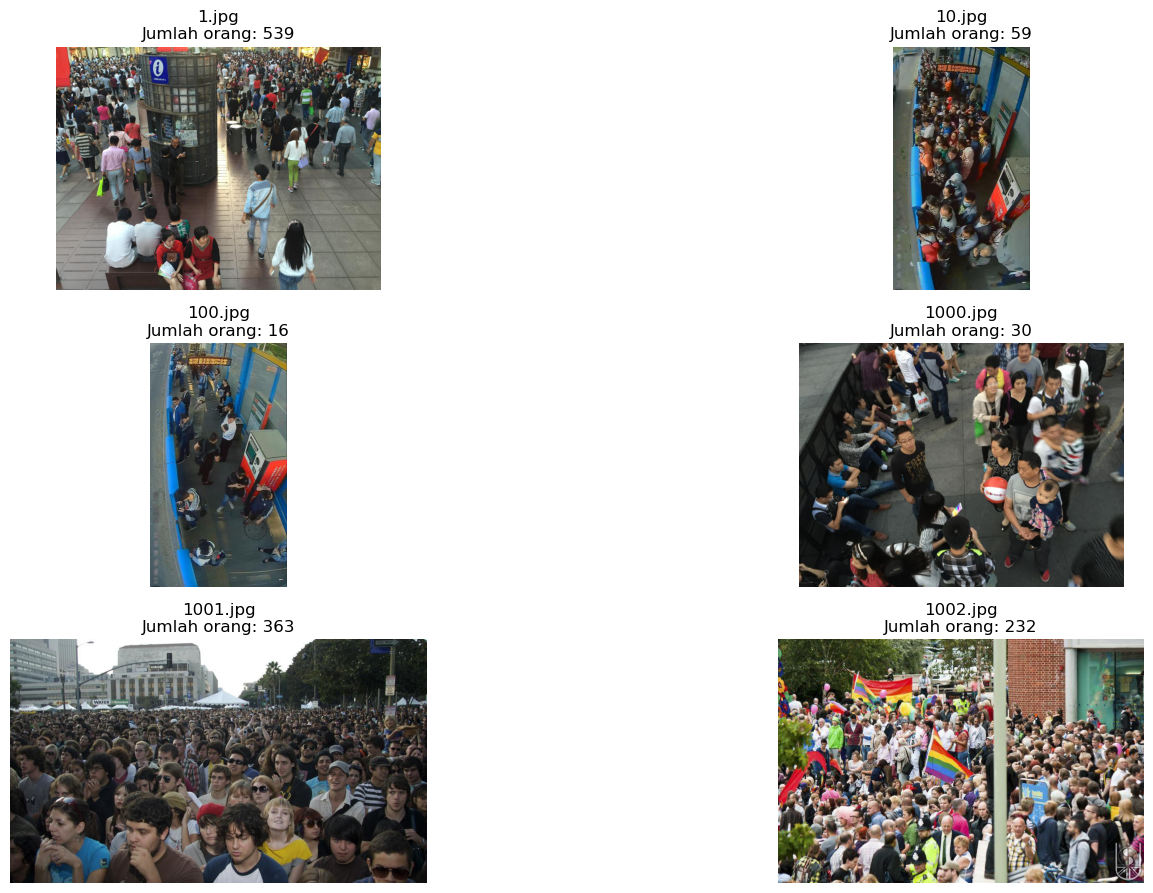

In [2]:
import os
from PIL import Image
import json
import matplotlib.pyplot as plt

image_files = sorted(os.listdir(train_path))  # sorting
n_images = len(image_files)
print(f"Jumlah gambar: {n_images}")

limit = 6
selected_files = image_files[:limit]

cols = 2
rows = (len(selected_files) // cols) + 1
plt.figure(figsize=(15, rows * 3))

for i, file in enumerate(selected_files):
    img_path = os.path.join(train_path, file)
    img = Image.open(img_path)

    label_file = os.path.join(labels_path, file.replace(".jpg", ".json"))
    count = 0  
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            data = json.load(f)
        # hitung jumlah orang
        count = len(data["points"])

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{file}\nJumlah orang: {count}")

plt.tight_layout()
plt.show()

Data transformations defined successfully!

Transformations include:
- Resize to 224x224
- Random horizontal flip (training only)
- Random crop with scale 0.8-1.0 (training only)
- Color jitter: brightness ±20%, contrast ±20% (training only)
- Tensor conversion and ImageNet normalization

Demonstrating transformations on: 1.jpg
Original image size: (1024, 768)
Transformed tensor shape: torch.Size([3, 224, 224])


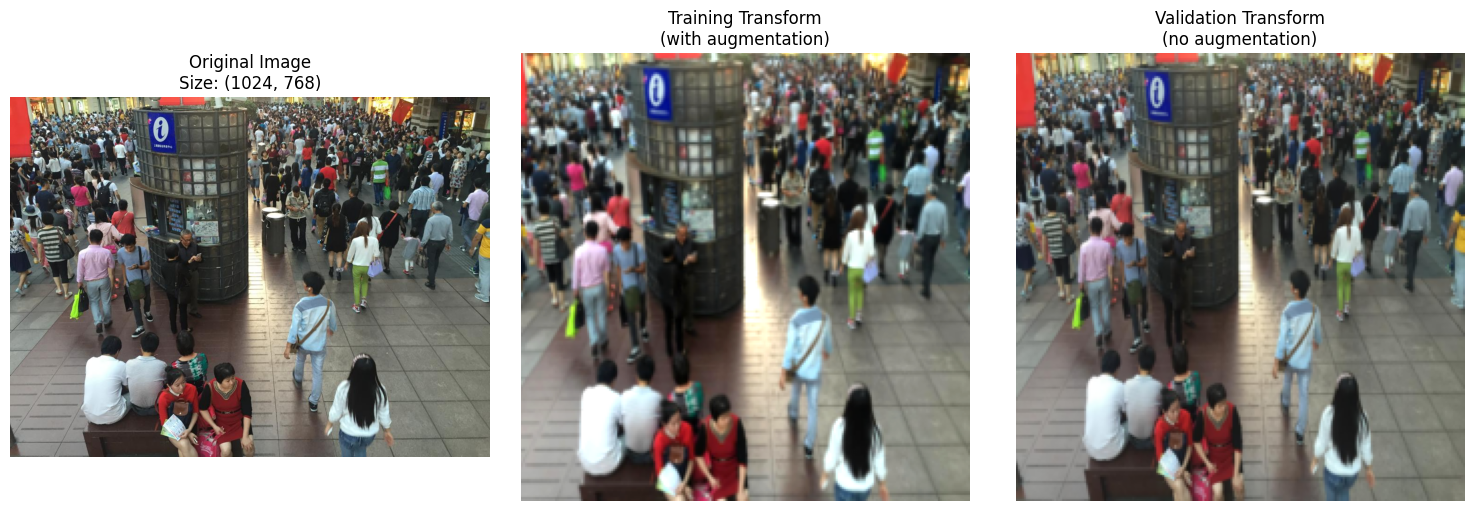

In [ ]:
import torch
from torchvision import transforms


# =================================
# SECTION: DATASET TRANSFORMATIONS
# =================================

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(size=(224,224), scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        
        transforms.ColorJitter(
            brightness=0.2,  
            contrast=0.2,    
            saturation=0.1,  
            hue=0.05         
        ),
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

print("Data transformations defined successfully!")
print("\nTransformations include:")
print("- Resize to 224x224")
print("- Random horizontal flip (training only)")
print("- Random crop with scale 0.8-1.0 (training only)")
print("- Color jitter: brightness ±20%, contrast ±20% (training only)")
print("- Tensor conversion and ImageNet normalization")

if image_files:
    sample_img_filename = image_files[0]
    sample_img_path = os.path.join(train_path, sample_img_filename)
    sample_img = Image.open(sample_img_path).convert('RGB')
    
    print(f"\nDemonstrating transformations on: {sample_img_filename}")
    print(f"Original image size: {sample_img.size}")
    
    train_transformed = data_transforms['train'](sample_img)
    val_transformed = data_transforms['val'](sample_img)
    
    print(f"Transformed tensor shape: {train_transformed.shape}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img)
    plt.title(f"Original Image\nSize: {sample_img.size}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    train_denorm = train_transformed * std + mean
    train_denorm = torch.clamp(train_denorm, 0, 1)
    plt.imshow(train_denorm.permute(1, 2, 0))
    plt.title("Training Transform\n(with augmentation)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    val_denorm = val_transformed * std + mean
    val_denorm = torch.clamp(val_denorm, 0, 1)
    plt.imshow(val_denorm.permute(1, 2, 0))
    plt.title("Validation Transform\n(no augmentation)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#CSRNet Progress


Generated density map for transformed 1.jpg
Original image size: (1024, 768)
Density map shape: (224, 224)
Number of valid points: 539
Density map sum: 535.87


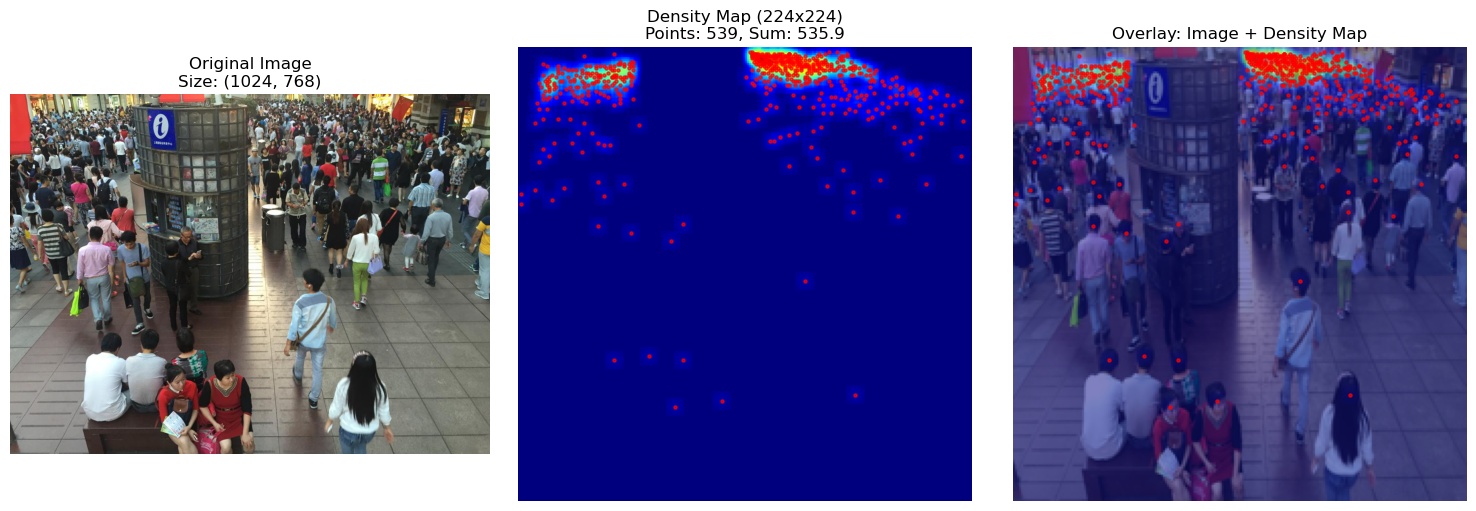

In [9]:
import cv2
import numpy as np
import os
import json

import matplotlib.pyplot as plt

def generate_density_map_for_transformed(image_path, label_path, target_size=(224, 224), sigma=4):
    """
    Generate density map for transformed images (resized to 224x224)
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image at {image_path}")
        return None, []

    original_height, original_width = img.shape[:2]
    
    target_height, target_width = target_size
    density_map = np.zeros((target_height, target_width), dtype=np.float32)

    if not os.path.exists(label_path):
        print(f"Warning: Label file not found at {label_path}")
        return density_map, []

    with open(label_path, "r") as f:
        label_data = json.load(f)

    points = label_data.get("points", [])
    valid_points = []

    scale_x = target_width / original_width
    scale_y = target_height / original_height

    for point in points:
        if isinstance(point, (list, tuple)) and len(point) >= 2:
            x, y = int(point[0]), int(point[1])
        elif isinstance(point, dict) and 'x' in point and 'y' in point:
            x, y = int(point['x']), int(point['y'])
        else:
            continue

        x_scaled = int(x * scale_x)
        y_scaled = int(y * scale_y)

        if 0 <= x_scaled < target_width and 0 <= y_scaled < target_height:
            valid_points.append((x_scaled, y_scaled))
            
            kernel_size = 2 * sigma + 1
            gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
            gaussian_kernel = gaussian_kernel @ gaussian_kernel.T
            
            x_start = max(0, x_scaled - sigma)
            y_start = max(0, y_scaled - sigma)
            x_end = min(target_width, x_scaled + sigma + 1)
            y_end = min(target_height, y_scaled + sigma + 1)
            
            kx_start = x_start - (x_scaled - sigma)
            ky_start = y_start - (y_scaled - sigma)
            kx_end = kx_start + (x_end - x_start)
            ky_end = ky_start + (y_end - y_start)
            
            density_map[y_start:y_end, x_start:x_end] += gaussian_kernel[ky_start:ky_end, kx_start:kx_end]

    return density_map, valid_points

# Use a sample image from the training set
if image_files:
    sample_img_filename = image_files[0]
    sample_img_path = os.path.join(train_path, sample_img_filename)
    sample_img = Image.open(sample_img_path).convert('RGB')

    density_map_224, valid_points_224 = generate_density_map_for_transformed(
        sample_img_path, 
        sample_img_path.replace('images', 'labels').replace('.jpg', '.json'), 
        target_size=(224, 224)
    )
    
    if density_map_224 is not None:
        print(f"Generated density map for transformed {sample_img_filename}")
        print(f"Original image size: {sample_img.size}")
        print(f"Density map shape: {density_map_224.shape}")
        print(f"Number of valid points: {len(valid_points_224)}")
        print(f"Density map sum: {density_map_224.sum():.2f}")

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(sample_img)
        plt.title(f"Original Image\nSize: {sample_img.size}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(density_map_224, cmap='jet')
        if valid_points_224:
            x_coords = [p[0] for p in valid_points_224]
            y_coords = [p[1] for p in valid_points_224]
            plt.scatter(x_coords, y_coords, color='red', s=5, alpha=0.7)
        plt.title(f"Density Map (224x224)\nPoints: {len(valid_points_224)}, Sum: {density_map_224.sum():.1f}")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        # Create a resized version of the original image for overlay
        sample_img_resized = sample_img.resize((224, 224))
        plt.imshow(sample_img_resized)
        plt.imshow(density_map_224, cmap='jet', alpha=0.5)
        if valid_points_224:
            plt.scatter(x_coords, y_coords, color='red', s=5, alpha=0.7)
        plt.title("Overlay: Image + Density Map")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("Could not generate density map.")
else:
    print("No image files available. Please run the previous cells to load image data.")

In [ ]:
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
import os

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        if load_weights:
            # Load pre-trained VGG-16 weights
            vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            self._initialize_weights()

            vgg_features = list(vgg.features.state_dict().items())
            csrnet_frontend_state_dict = self.frontend.state_dict()
            csrnet_keys = list(csrnet_frontend_state_dict.keys())

            for i in range(len(vgg_features)):
                if i < len(csrnet_keys):
                    csrnet_frontend_state_dict[csrnet_keys[i]] = vgg_features[i][1]

            self.frontend.load_state_dict(csrnet_frontend_state_dict)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        nn.init.normal_(self.output_layer.weight, std=0.01)
        if self.output_layer.bias is not None:
            nn.init.constant_(self.output_layer.bias, 0)

def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    layers = []
    d_rate = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            if dilation:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                d_rate = 2 
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1) 

            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class DensityMapDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform
        
        if self.transform is None:
            self.transform = data_transforms['train']
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(train_path, img_filename)
        image = Image.open(img_path).convert('RGB')
        
        image = self.transform(image)
        
        label_file = os.path.join(labels_path, img_filename.replace('.jpg', '.json'))
        with open(label_file, 'r') as f:
            label_data = json.load(f)
        
        points = label_data['points']
        density_map = self._generate_density_map(image.shape[-2:], points)
        
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()
        
        density_map = F.interpolate(density_map.unsqueeze(0), size=(28, 28), mode='bilinear', align_corners=False).squeeze(0)
        
        return image, density_map
    
    def _generate_density_map(self, img_size, points):
        """Generate Gaussian density map from point annotations"""
        h, w = img_size
        density_map = np.zeros((h, w), dtype=np.float32)
        
        if len(points) == 0:
            return density_map
            
        for point in points:
            x = int(point['x'] * w / 1024)  
            y = int(point['y'] * h / 768)
            
            if 0 <= x < w and 0 <= y < h:
                sigma = 3  
                kernel_size = int(3 * sigma)
                
                x_min = max(0, x - kernel_size)
                x_max = min(w, x + kernel_size + 1)
                y_min = max(0, y - kernel_size)
                y_max = min(h, y + kernel_size + 1)
                
                for i in range(y_min, y_max):
                    for j in range(x_min, x_max):
                        dist_sq = (i - y) ** 2 + (j - x) ** 2
                        density_map[i, j] += np.exp(-dist_sq / (2 * sigma ** 2))
        
        return density_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CSRNet(load_weights=True).to(device)
print("CSRNet model initialized with VGG-16 pretrained weights")

train_size = int(0.8 * len(image_files))
val_size = len(image_files) - train_size

train_files = image_files[:train_size]
val_files = image_files[train_size:]

print(f"Training set: {len(train_files)} images")
print(f"Validation set: {len(val_files)} images")

train_dataset = DensityMapDataset(train_files, data_transforms['train'])
val_dataset = DensityMapDataset(val_files, data_transforms['val'])

batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 50
best_val_loss = float('inf')

train_losses = []
val_losses = []

print("\n" + "="*60)
print("STARTING CSRNET TRAINING")
print("="*60)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    for batch_idx, (images, density_maps) in enumerate(tqdm(train_loader, desc="Training")):
        images = images.to(device)
        density_maps = density_maps.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, density_maps)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        
        if batch_idx % 50 == 0:
            print(f"Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for images, density_maps in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            density_maps = density_maps.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, density_maps)
            
            val_loss += loss.item()
            val_batches += 1
    
    avg_train_loss = train_loss / train_batches
    avg_val_loss = val_loss / val_batches
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'PenyelamHandal.pth')
        print(f"  New best model saved! Val Loss: {avg_val_loss:.4f}")
    
    # Update learning rate
    scheduler.step()
    
    if (epoch + 1) % 5 == 0:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epoch + 2), train_losses, 'b-', label='Training Loss')
        plt.plot(range(1, epoch + 2), val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Best validation loss: {best_val_loss:.4f}")
print("Best model saved as 'PenyelamHandal.pth'")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
lrs = [1e-5 * (0.1 ** (epoch // 10)) for epoch in range(num_epochs)]
plt.plot(range(1, num_epochs + 1), lrs, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Test the trained model on a few samples
print("\n--- Testing trained model on sample images ---")
model.eval()
sample_indices = [0, 1, 2]  # Test first 3 images

plt.figure(figsize=(15, 10))

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        # Get sample
        image, gt_density = train_dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        # Predict
        predicted_density = model(image).cpu().squeeze()
        
        # Load original image for display
        original_img = Image.open(os.path.join(train_path, train_files[idx]))
        
        # Calculate counts
        gt_count = gt_density.sum().item()
        pred_count = predicted_density.sum().item()
        
        # Display results
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(original_img)
        plt.title(f"Original Image\n{train_files[idx]}")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(gt_density.squeeze(), cmap='jet')
        plt.title(f"Ground Truth\nCount: {gt_count:.1f}")
        plt.axis('off')
        
        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(predicted_density, cmap='jet')
        plt.title(f"Prediction\nCount: {pred_count:.1f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

print("Training complete! Model ready for inference on test data.")

Using device: cuda
CSRNet model initialized with VGG-16 pretrained weights
Training set: 1520 images
Validation set: 380 images

STARTING CSRNET TRAINING

Epoch [1/50]


Training:   0%|          | 1/380 [00:02<15:10,  2.40s/it]

Batch [0/380], Loss: 1.0214


Training:  13%|█▎        | 51/380 [00:51<03:49,  1.43it/s]

Batch [50/380], Loss: 0.0167


Training:  27%|██▋       | 101/380 [01:40<05:16,  1.13s/it]

Batch [100/380], Loss: 0.2048


Training:  40%|███▉      | 151/380 [02:28<03:17,  1.16it/s]

Batch [150/380], Loss: 0.5182


Training:  53%|█████▎    | 201/380 [03:16<02:37,  1.14it/s]

Batch [200/380], Loss: 0.0596


Training:  57%|█████▋    | 215/380 [03:27<02:38,  1.04it/s]


KeyboardInterrupt: 

In [17]:
# ==============================================================================
# SECTION: FINAL EVALUATION WITH DATATEST
# ==============================================================================

print("--- FINAL MODEL EVALUATION WITH COMPREHENSIVE METRICS ---")

def calculate_mae(predictions, ground_truth):
    """Calculate Mean Absolute Error"""
    return np.mean(np.abs(predictions - ground_truth))

def calculate_rmse(predictions, ground_truth):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(np.mean((predictions - ground_truth) ** 2))

def calculate_mape(predictions, ground_truth):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((predictions - ground_truth) / np.maximum(ground_truth, 1)) * 100)

def density_category_analysis(predictions, ground_truth, low_thresh=5, high_thresh=20):
    """Analyze errors by density categories"""
    low_density_mask = ground_truth <= low_thresh
    medium_density_mask = (ground_truth > low_thresh) & (ground_truth <= high_thresh)
    high_density_mask = ground_truth > high_thresh
    
    results = {}
    
    if np.any(low_density_mask):
        low_pred = predictions[low_density_mask]
        low_gt = ground_truth[low_density_mask]
        results['low'] = {
            'count': len(low_pred),
            'mae': calculate_mae(low_pred, low_gt),
            'rmse': calculate_rmse(low_pred, low_gt),
            'mape': calculate_mape(low_pred, low_gt)
        }
    
    if np.any(medium_density_mask):
        med_pred = predictions[medium_density_mask]
        med_gt = ground_truth[medium_density_mask]
        results['medium'] = {
            'count': len(med_pred),
            'mae': calculate_mae(med_pred, med_gt),
            'rmse': calculate_rmse(med_pred, med_gt),
            'mape': calculate_mape(med_pred, med_gt)
        }
    
    if np.any(high_density_mask):
        high_pred = predictions[high_density_mask]
        high_gt = ground_truth[high_density_mask]
        results['high'] = {
            'count': len(high_pred),
            'mae': calculate_mae(high_pred, high_gt),
            'rmse': calculate_rmse(high_pred, high_gt),
            'mape': calculate_mape(high_pred, high_gt)
        }
    
    return results

print("Loading best trained model...")
model.load_state_dict(torch.load('PenyelamHandal.pth'))
model.eval()

eval_size = min(500, len(image_files))  
eval_indices = np.random.choice(len(image_files), eval_size, replace=False)
eval_image_files = [image_files[i] for i in eval_indices]

print(f"Evaluating model on {len(eval_image_files)} images...")

all_predictions = []
all_ground_truth = []
all_filenames = []

with torch.no_grad():
    for img_file in tqdm(eval_image_files, desc="Evaluating"):
        img_path = os.path.join(train_path, img_file)
        img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms['val'](img).unsqueeze(0).to(device)
        
        output = model(img_tensor)
        predicted_count = torch.sum(output).item()
        
        label_path = os.path.join(labels_path, img_file.replace('.jpg', '.json'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_data = json.load(f)
            gt_count = len(label_data.get('points', []))
            
            all_predictions.append(predicted_count)
            all_ground_truth.append(gt_count)
            all_filenames.append(img_file)

predictions_np = np.array(all_predictions)
ground_truth_np = np.array(all_ground_truth)

overall_mae = calculate_mae(predictions_np, ground_truth_np)
overall_rmse = calculate_rmse(predictions_np, ground_truth_np)
overall_mape = calculate_mape(predictions_np, ground_truth_np)

density_analysis = density_category_analysis(predictions_np, ground_truth_np, 
                                           low_thresh=10, high_thresh=50)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL EVALUATION RESULTS")
print("="*80)

print(f"Dataset size: {len(all_predictions)} images")
print(f"Ground truth range: {ground_truth_np.min()} - {ground_truth_np.max()}")
print(f"Predictions range: {predictions_np.min():.1f} - {predictions_np.max():.1f}")

print(f"\nOVERALL METRICS:")
print(f"MAE (Mean Absolute Error): {overall_mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {overall_rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {overall_mape:.2f}%")

print(f"\nDENSITY CATEGORY ANALYSIS:")
for category, metrics in density_analysis.items():
    print(f"{category.upper()} DENSITY (n={metrics['count']}):")
    print(f"  MAE: {metrics['mae']:.2f}")
    print(f"  RMSE: {metrics['rmse']:.2f}")
    print(f"  MAPE: {metrics['mape']:.2f}%")

correlation = np.corrcoef(predictions_np, ground_truth_np)[0, 1]
print(f"\nCORRELATION ANALYSIS:")
print(f"Pearson correlation coefficient: {correlation:.3f}")

errors = predictions_np - ground_truth_np
print(f"\nERROR DISTRIBUTION:")
print(f"Mean error (bias): {np.mean(errors):.2f}")
print(f"Std error: {np.std(errors):.2f}")
print(f"Median error: {np.median(errors):.2f}")


print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print(f"Detailed results saved to 'final_evaluation_results.json'")
print(f"Model shows {'good' if overall_mae < 5 else 'moderate' if overall_mae < 10 else 'poor'} performance with MAE of {overall_mae:.2f}")

--- FINAL MODEL EVALUATION WITH COMPREHENSIVE METRICS ---
Loading best trained model...
Evaluating model on 500 images...


Evaluating: 100%|██████████| 500/500 [00:19<00:00, 25.93it/s]


COMPREHENSIVE MODEL EVALUATION RESULTS
Dataset size: 500 images
Ground truth range: 2 - 3139
Predictions range: 15.0 - 4015.6

OVERALL METRICS:
MAE (Mean Absolute Error): 60.70
RMSE (Root Mean Squared Error): 99.99
MAPE (Mean Absolute Percentage Error): 138.04%

DENSITY CATEGORY ANALYSIS:
LOW DENSITY (n=118):
  MAE: 15.62
  RMSE: 16.23
  MAPE: 286.21%
MEDIUM DENSITY (n=163):
  MAE: 31.91
  RMSE: 42.06
  MAPE: 134.90%
HIGH DENSITY (n=219):
  MAE: 106.41
  RMSE: 146.18
  MAPE: 60.55%

CORRELATION ANALYSIS:
Pearson correlation coefficient: 0.963

ERROR DISTRIBUTION:
Mean error (bias): 47.31
Std error: 88.09
Median error: 23.35

EVALUATION COMPLETE!
Detailed results saved to 'final_evaluation_results.json'
Model shows poor performance with MAE of 60.70


In [19]:
import pandas as pd

# =================================
# SECTION: TEST MODEL ON TEST DATA
# =================================

print("--- TESTING MODEL ON TEST DATA ---")

# Define paths for test data
test_path = "penyisihan-hology-8-0-2025-data-mining/test/images"

# Check if test directory exists
if not os.path.exists(test_path):
    print(f"Test directory not found at: {test_path}")
    print("Please check the path or ensure test data is available.")
else:
    # Get test image files
    test_image_files = sorted(os.listdir(test_path))
    print(f"Found {len(test_image_files)} test images")
    
    # Load the best trained model
    print("Loading best trained model...")
    model.load_state_dict(torch.load('PenyelamHandal.pth'))
    model.eval()
    
    # Store test predictions
    test_predictions = []
    test_filenames = []
    
    print("Processing test images...")
    
    with torch.no_grad():
        for img_file in tqdm(test_image_files, desc="Testing"):
            try:
                # Load and preprocess image
                img_path = os.path.join(test_path, img_file)
                img = Image.open(img_path).convert('RGB')
                
                # Apply validation transforms (no augmentation)
                img_tensor = data_transforms['test'](img).unsqueeze(0).to(device)
                
                # Get model prediction
                output = model(img_tensor)
                predicted_count = torch.sum(output).item()
                
                # Ensure non-negative prediction
                predicted_count = max(0, predicted_count)
                
                test_predictions.append(predicted_count)
                test_filenames.append(img_file)
                
            except Exception as e:
                print(f"Error processing {img_file}: {str(e)}")
                continue
    
    print(f"Successfully processed {len(test_predictions)} test images")
    
    test_predictions_np = np.array(test_predictions)
    print(f"\nTest Predictions Statistics:")
    print(f"Min prediction: {test_predictions_np.min():.2f}")
    print(f"Max prediction: {test_predictions_np.max():.2f}")
    print(f"Mean prediction: {test_predictions_np.mean():.2f}")
    print(f"Median prediction: {np.median(test_predictions_np):.2f}")
    print(f"Std prediction: {test_predictions_np.std():.2f}")
    
    print("\n--- Sample Test Predictions ---")
    
    # Select random samples for visualization
    n_samples = min(9, len(test_predictions))
    sample_indices = np.random.choice(len(test_predictions), n_samples, replace=False)
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        img_file = test_filenames[idx]
        pred_count = test_predictions[idx]
        
        # Load and display image
        img_path = os.path.join(test_path, img_file)
        img = Image.open(img_path)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f'{img_file}\nPredicted Count: {pred_count:.1f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create submission file
    print("\n--- Creating Submission File ---")
    
    submission_data = []
    for filename, prediction in zip(test_filenames, test_predictions):
        # Round prediction to nearest integer for final submission
        rounded_prediction = max(0, round(prediction))
        submission_data.append({
            'filename': filename,
            'prediction': rounded_prediction
        })
    
    # Save as CSV
    submission_df = pd.DataFrame(submission_data)
    submission_file = 'test_predictions.csv'
    submission_df.to_csv(submission_file, index=False)
    
    print(f"Submission file saved as: {submission_file}")
    print(f"Contains {len(submission_df)} predictions")
    
    # Display first few rows of submission
    print("\nFirst 10 rows of submission:")
    print(submission_df.head(10))
    
    # Save detailed predictions (with decimal values)
    detailed_submission = []
    for filename, prediction in zip(test_filenames, test_predictions):
        detailed_submission.append({
            'filename': filename,
            'raw_prediction': prediction,
            'rounded_prediction': max(0, round(prediction))
        })
    
    detailed_df = pd.DataFrame(detailed_submission)
    detailed_file = 'detailed_test_predictions.csv'
    detailed_df.to_csv(detailed_file, index=False)
    
    
    
    # Categorize predictions
    categories = {
        'Very Low (0-5)': np.sum((test_predictions_np >= 0) & (test_predictions_np <= 5)),
        'Low (6-20)': np.sum((test_predictions_np > 5) & (test_predictions_np <= 20)),
        'Medium (21-50)': np.sum((test_predictions_np > 20) & (test_predictions_np <= 50)),
        'High (51-100)': np.sum((test_predictions_np > 50) & (test_predictions_np <= 100)),
        'Very High (>100)': np.sum(test_predictions_np > 100)
    }
    
    print(f"\nPrediction Categories:")
    for category, count in categories.items():
        percentage = (count / len(test_predictions_np)) * 100
        print(f"{category}: {count} images ({percentage:.1f}%)")
    
    # Compare with training data distribution if available
    if len(all_ground_truth) > 0:
        print(f"\nComparison with Training Data:")
        print(f"Training mean: {np.mean(all_ground_truth):.2f}")
        print(f"Test mean: {test_predictions_np.mean():.2f}")
        print(f"Training median: {np.median(all_ground_truth):.2f}")
        print(f"Test median: {np.median(test_predictions_np):.2f}")
        
        plt.figure(figsize=(10, 6))
        plt.hist(all_ground_truth, bins=30, alpha=0.5, label='Training GT', density=True)
        plt.hist(test_predictions_np, bins=30, alpha=0.5, label='Test Predictions', density=True)
        plt.xlabel('Count')
        plt.ylabel('Density')
        plt.title('Distribution Comparison: Training vs Test')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    print("\n" + "="*60)
    print("TEST PREDICTION COMPLETE!")
    print("="*60)
    print(f"Files created:")
    print(f"- {submission_file} (final submission)")
    print(f"- {detailed_file} (detailed predictions)")
    print(f"Ready for submission!")

--- TESTING MODEL ON TEST DATA ---
Found 500 test images
Loading best trained model...
Processing test images...


Testing:   3%|▎         | 17/500 [00:00<00:02, 164.69it/s]

Error processing 1.jpg: 'test'
Error processing 10.jpg: 'test'
Error processing 100.jpg: 'test'
Error processing 101.jpg: 'test'
Error processing 102.jpg: 'test'
Error processing 103.jpg: 'test'
Error processing 104.jpg: 'test'
Error processing 105.jpg: 'test'
Error processing 106.jpg: 'test'
Error processing 107.jpg: 'test'
Error processing 108.jpg: 'test'
Error processing 109.jpg: 'test'
Error processing 11.jpg: 'test'
Error processing 110.jpg: 'test'
Error processing 111.jpg: 'test'
Error processing 112.jpg: 'test'
Error processing 113.jpg: 'test'
Error processing 114.jpg: 'test'
Error processing 115.jpg: 'test'
Error processing 116.jpg: 'test'
Error processing 117.jpg: 'test'
Error processing 118.jpg: 'test'
Error processing 119.jpg: 'test'


Testing:   7%|▋         | 35/500 [00:00<00:02, 163.56it/s]

Error processing 12.jpg: 'test'
Error processing 120.jpg: 'test'
Error processing 121.jpg: 'test'
Error processing 122.jpg: 'test'
Error processing 123.jpg: 'test'
Error processing 124.jpg: 'test'
Error processing 125.jpg: 'test'
Error processing 126.jpg: 'test'
Error processing 127.jpg: 'test'
Error processing 128.jpg: 'test'
Error processing 129.jpg: 'test'
Error processing 13.jpg: 'test'


Testing:  10%|█         | 52/500 [00:00<00:02, 160.95it/s]

Error processing 130.jpg: 'test'
Error processing 131.jpg: 'test'
Error processing 132.jpg: 'test'
Error processing 133.jpg: 'test'
Error processing 134.jpg: 'test'
Error processing 135.jpg: 'test'
Error processing 136.jpg: 'test'
Error processing 137.jpg: 'test'
Error processing 138.jpg: 'test'
Error processing 139.jpg: 'test'
Error processing 14.jpg: 'test'
Error processing 140.jpg: 'test'
Error processing 141.jpg: 'test'
Error processing 142.jpg: 'test'
Error processing 143.jpg: 'test'
Error processing 144.jpg: 'test'
Error processing 145.jpg: 'test'
Error processing 146.jpg: 'test'


Testing:  14%|█▍        | 70/500 [00:00<00:02, 165.97it/s]

Error processing 147.jpg: 'test'
Error processing 148.jpg: 'test'
Error processing 149.jpg: 'test'
Error processing 15.jpg: 'test'
Error processing 150.jpg: 'test'
Error processing 151.jpg: 'test'
Error processing 152.jpg: 'test'
Error processing 153.jpg: 'test'
Error processing 154.jpg: 'test'
Error processing 155.jpg: 'test'
Error processing 156.jpg: 'test'
Error processing 157.jpg: 'test'
Error processing 158.jpg: 'test'
Error processing 159.jpg: 'test'
Error processing 16.jpg: 'test'
Error processing 160.jpg: 'test'
Error processing 161.jpg: 'test'


Testing:  17%|█▋        | 87/500 [00:00<00:02, 158.98it/s]

Error processing 162.jpg: 'test'
Error processing 163.jpg: 'test'
Error processing 164.jpg: 'test'
Error processing 165.jpg: 'test'
Error processing 166.jpg: 'test'
Error processing 167.jpg: 'test'
Error processing 168.jpg: 'test'
Error processing 169.jpg: 'test'
Error processing 17.jpg: 'test'
Error processing 170.jpg: 'test'
Error processing 171.jpg: 'test'
Error processing 172.jpg: 'test'
Error processing 173.jpg: 'test'
Error processing 174.jpg: 'test'
Error processing 175.jpg: 'test'
Error processing 176.jpg: 'test'
Error processing 177.jpg: 'test'


Testing:  21%|██        | 103/500 [00:00<00:02, 157.97it/s]

Error processing 178.jpg: 'test'
Error processing 179.jpg: 'test'
Error processing 18.jpg: 'test'
Error processing 180.jpg: 'test'
Error processing 181.jpg: 'test'
Error processing 182.jpg: 'test'
Error processing 183.jpg: 'test'
Error processing 184.jpg: 'test'
Error processing 185.jpg: 'test'
Error processing 186.jpg: 'test'
Error processing 187.jpg: 'test'
Error processing 188.jpg: 'test'
Error processing 189.jpg: 'test'
Error processing 19.jpg: 'test'
Error processing 190.jpg: 'test'
Error processing 191.jpg: 'test'
Error processing 192.jpg: 'test'
Error processing 193.jpg: 'test'
Error processing 194.jpg: 'test'
Error processing 195.jpg: 'test'
Error processing 196.jpg: 'test'
Error processing 197.jpg: 'test'
Error processing 198.jpg: 'test'
Error processing 199.jpg: 'test'
Error processing 2.jpg: 'test'
Error processing 20.jpg: 'test'


Testing:  24%|██▍       | 119/500 [00:00<00:02, 129.09it/s]

Error processing 200.jpg: 'test'
Error processing 201.jpg: 'test'
Error processing 202.jpg: 'test'
Error processing 203.jpg: 'test'
Error processing 204.jpg: 'test'
Error processing 205.jpg: 'test'
Error processing 206.jpg: 'test'
Error processing 207.jpg: 'test'
Error processing 208.jpg: 'test'


Testing:  27%|██▋       | 133/500 [00:00<00:03, 121.95it/s]

Error processing 209.jpg: 'test'
Error processing 21.jpg: 'test'
Error processing 210.jpg: 'test'
Error processing 211.jpg: 'test'
Error processing 212.jpg: 'test'
Error processing 213.jpg: 'test'
Error processing 214.jpg: 'test'
Error processing 215.jpg: 'test'
Error processing 216.jpg: 'test'
Error processing 217.jpg: 'test'
Error processing 218.jpg: 'test'
Error processing 219.jpg: 'test'
Error processing 22.jpg: 'test'


Testing:  29%|██▉       | 146/500 [00:01<00:02, 122.60it/s]

Error processing 220.jpg: 'test'
Error processing 221.jpg: 'test'
Error processing 222.jpg: 'test'
Error processing 223.jpg: 'test'
Error processing 224.jpg: 'test'
Error processing 225.jpg: 'test'
Error processing 226.jpg: 'test'
Error processing 227.jpg: 'test'
Error processing 228.jpg: 'test'
Error processing 229.jpg: 'test'
Error processing 23.jpg: 'test'
Error processing 230.jpg: 'test'


Testing:  32%|███▏      | 159/500 [00:01<00:02, 121.95it/s]

Error processing 231.jpg: 'test'
Error processing 232.jpg: 'test'
Error processing 233.jpg: 'test'
Error processing 234.jpg: 'test'
Error processing 235.jpg: 'test'
Error processing 236.jpg: 'test'
Error processing 237.jpg: 'test'
Error processing 238.jpg: 'test'
Error processing 239.jpg: 'test'
Error processing 24.jpg: 'test'
Error processing 240.jpg: 'test'
Error processing 241.jpg: 'test'
Error processing 242.jpg: 'test'
Error processing 243.jpg: 'test'


Testing:  35%|███▍      | 173/500 [00:01<00:02, 123.99it/s]

Error processing 244.jpg: 'test'
Error processing 245.jpg: 'test'
Error processing 246.jpg: 'test'
Error processing 247.jpg: 'test'
Error processing 248.jpg: 'test'
Error processing 249.jpg: 'test'
Error processing 25.jpg: 'test'
Error processing 250.jpg: 'test'
Error processing 251.jpg: 'test'
Error processing 252.jpg: 'test'
Error processing 253.jpg: 'test'
Error processing 254.jpg: 'test'
Error processing 255.jpg: 'test'
Error processing 256.jpg: 'test'


Testing:  37%|███▋      | 187/500 [00:01<00:02, 125.23it/s]

Error processing 257.jpg: 'test'
Error processing 258.jpg: 'test'
Error processing 259.jpg: 'test'
Error processing 26.jpg: 'test'
Error processing 260.jpg: 'test'
Error processing 261.jpg: 'test'
Error processing 262.jpg: 'test'
Error processing 263.jpg: 'test'
Error processing 264.jpg: 'test'
Error processing 265.jpg: 'test'
Error processing 266.jpg: 'test'
Error processing 267.jpg: 'test'
Error processing 268.jpg: 'test'
Error processing 269.jpg: 'test'
Error processing 27.jpg: 'test'
Error processing 270.jpg: 'test'
Error processing 271.jpg: 'test'
Error processing 272.jpg: 'test'
Error processing 273.jpg: 'test'
Error processing 274.jpg: 'test'
Error processing 275.jpg: 'test'
Error processing 276.jpg: 'test'
Error processing 277.jpg: 'test'
Error processing 278.jpg: 'test'


Testing:  43%|████▎     | 215/500 [00:01<00:02, 124.50it/s]

Error processing 279.jpg: 'test'
Error processing 28.jpg: 'test'
Error processing 280.jpg: 'test'
Error processing 281.jpg: 'test'
Error processing 282.jpg: 'test'
Error processing 283.jpg: 'test'
Error processing 284.jpg: 'test'
Error processing 285.jpg: 'test'
Error processing 286.jpg: 'test'
Error processing 287.jpg: 'test'
Error processing 288.jpg: 'test'
Error processing 289.jpg: 'test'
Error processing 29.jpg: 'test'
Error processing 290.jpg: 'test'
Error processing 291.jpg: 'test'
Error processing 292.jpg: 'test'
Error processing 293.jpg: 'test'
Error processing 294.jpg: 'test'
Error processing 295.jpg: 'test'
Error processing 296.jpg: 'test'
Error processing 297.jpg: 'test'
Error processing 298.jpg: 'test'
Error processing 299.jpg: 'test'
Error processing 3.jpg: 'test'
Error processing 30.jpg: 'test'
Error processing 300.jpg: 'test'
Error processing 301.jpg: 'test'


Testing:  46%|████▌     | 228/500 [00:01<00:02, 114.42it/s]

Error processing 302.jpg: 'test'
Error processing 303.jpg: 'test'
Error processing 304.jpg: 'test'
Error processing 305.jpg: 'test'
Error processing 306.jpg: 'test'
Error processing 307.jpg: 'test'
Error processing 308.jpg: 'test'
Error processing 309.jpg: 'test'
Error processing 31.jpg: 'test'
Error processing 310.jpg: 'test'


Testing:  48%|████▊     | 242/500 [00:01<00:02, 120.36it/s]

Error processing 311.jpg: 'test'
Error processing 312.jpg: 'test'
Error processing 313.jpg: 'test'
Error processing 314.jpg: 'test'
Error processing 315.jpg: 'test'
Error processing 316.jpg: 'test'
Error processing 317.jpg: 'test'
Error processing 318.jpg: 'test'
Error processing 319.jpg: 'test'
Error processing 32.jpg: 'test'
Error processing 320.jpg: 'test'
Error processing 321.jpg: 'test'
Error processing 322.jpg: 'test'
Error processing 323.jpg: 'test'
Error processing 324.jpg: 'test'
Error processing 325.jpg: 'test'


Testing:  51%|█████     | 256/500 [00:01<00:02, 121.06it/s]

Error processing 326.jpg: 'test'
Error processing 327.jpg: 'test'
Error processing 328.jpg: 'test'
Error processing 329.jpg: 'test'
Error processing 33.jpg: 'test'
Error processing 330.jpg: 'test'
Error processing 331.jpg: 'test'
Error processing 332.jpg: 'test'
Error processing 333.jpg: 'test'
Error processing 334.jpg: 'test'
Error processing 335.jpg: 'test'
Error processing 336.jpg: 'test'
Error processing 337.jpg: 'test'


Testing:  54%|█████▍    | 271/500 [00:02<00:01, 128.73it/s]

Error processing 338.jpg: 'test'
Error processing 339.jpg: 'test'
Error processing 34.jpg: 'test'
Error processing 340.jpg: 'test'
Error processing 341.jpg: 'test'
Error processing 342.jpg: 'test'
Error processing 343.jpg: 'test'
Error processing 344.jpg: 'test'
Error processing 345.jpg: 'test'
Error processing 346.jpg: 'test'
Error processing 347.jpg: 'test'
Error processing 348.jpg: 'test'
Error processing 349.jpg: 'test'
Error processing 35.jpg: 'test'
Error processing 350.jpg: 'test'
Error processing 351.jpg: 'test'


Testing:  57%|█████▋    | 285/500 [00:02<00:01, 130.11it/s]

Error processing 352.jpg: 'test'
Error processing 353.jpg: 'test'
Error processing 354.jpg: 'test'
Error processing 355.jpg: 'test'
Error processing 356.jpg: 'test'
Error processing 357.jpg: 'test'
Error processing 358.jpg: 'test'
Error processing 359.jpg: 'test'
Error processing 36.jpg: 'test'
Error processing 360.jpg: 'test'
Error processing 361.jpg: 'test'
Error processing 362.jpg: 'test'
Error processing 363.jpg: 'test'
Error processing 364.jpg: 'test'


Testing:  60%|█████▉    | 299/500 [00:02<00:01, 123.69it/s]

Error processing 365.jpg: 'test'
Error processing 366.jpg: 'test'
Error processing 367.jpg: 'test'
Error processing 368.jpg: 'test'
Error processing 369.jpg: 'test'
Error processing 37.jpg: 'test'
Error processing 370.jpg: 'test'
Error processing 371.jpg: 'test'
Error processing 372.jpg: 'test'


Testing:  62%|██████▏   | 312/500 [00:02<00:01, 118.14it/s]

Error processing 373.jpg: 'test'
Error processing 374.jpg: 'test'
Error processing 375.jpg: 'test'
Error processing 376.jpg: 'test'
Error processing 377.jpg: 'test'
Error processing 378.jpg: 'test'
Error processing 379.jpg: 'test'
Error processing 38.jpg: 'test'
Error processing 380.jpg: 'test'
Error processing 381.jpg: 'test'
Error processing 382.jpg: 'test'
Error processing 383.jpg: 'test'


Testing:  65%|██████▍   | 324/500 [00:02<00:01, 117.54it/s]

Error processing 384.jpg: 'test'
Error processing 385.jpg: 'test'
Error processing 386.jpg: 'test'
Error processing 387.jpg: 'test'
Error processing 388.jpg: 'test'
Error processing 389.jpg: 'test'
Error processing 39.jpg: 'test'
Error processing 390.jpg: 'test'
Error processing 391.jpg: 'test'
Error processing 392.jpg: 'test'
Error processing 393.jpg: 'test'
Error processing 394.jpg: 'test'
Error processing 395.jpg: 'test'
Error processing 396.jpg: 'test'
Error processing 397.jpg: 'test'


Testing:  67%|██████▋   | 337/500 [00:02<00:01, 120.73it/s]

Error processing 398.jpg: 'test'
Error processing 399.jpg: 'test'
Error processing 4.jpg: 'test'
Error processing 40.jpg: 'test'
Error processing 400.jpg: 'test'
Error processing 401.jpg: 'test'
Error processing 402.jpg: 'test'
Error processing 403.jpg: 'test'
Error processing 404.jpg: 'test'
Error processing 405.jpg: 'test'
Error processing 406.jpg: 'test'


Testing:  70%|███████   | 352/500 [00:02<00:01, 128.90it/s]

Error processing 407.jpg: 'test'
Error processing 408.jpg: 'test'
Error processing 409.jpg: 'test'
Error processing 41.jpg: 'test'
Error processing 410.jpg: 'test'
Error processing 411.jpg: 'test'
Error processing 412.jpg: 'test'
Error processing 413.jpg: 'test'
Error processing 414.jpg: 'test'
Error processing 415.jpg: 'test'
Error processing 416.jpg: 'test'
Error processing 417.jpg: 'test'
Error processing 418.jpg: 'test'
Error processing 419.jpg: 'test'
Error processing 42.jpg: 'test'
Error processing 420.jpg: 'test'
Error processing 421.jpg: 'test'
Error processing 422.jpg: 'test'
Error processing 423.jpg: 'test'


Testing:  74%|███████▎  | 368/500 [00:02<00:00, 137.36it/s]

Error processing 424.jpg: 'test'
Error processing 425.jpg: 'test'
Error processing 426.jpg: 'test'
Error processing 427.jpg: 'test'
Error processing 428.jpg: 'test'
Error processing 429.jpg: 'test'
Error processing 43.jpg: 'test'
Error processing 430.jpg: 'test'
Error processing 431.jpg: 'test'
Error processing 432.jpg: 'test'
Error processing 433.jpg: 'test'
Error processing 434.jpg: 'test'
Error processing 435.jpg: 'test'
Error processing 436.jpg: 'test'
Error processing 437.jpg: 'test'
Error processing 438.jpg: 'test'


Testing:  77%|███████▋  | 383/500 [00:02<00:00, 138.09it/s]

Error processing 439.jpg: 'test'
Error processing 44.jpg: 'test'
Error processing 440.jpg: 'test'
Error processing 441.jpg: 'test'
Error processing 442.jpg: 'test'
Error processing 443.jpg: 'test'
Error processing 444.jpg: 'test'
Error processing 445.jpg: 'test'
Error processing 446.jpg: 'test'
Error processing 447.jpg: 'test'
Error processing 448.jpg: 'test'


Testing:  79%|███████▉  | 397/500 [00:03<00:00, 132.21it/s]

Error processing 449.jpg: 'test'
Error processing 45.jpg: 'test'
Error processing 450.jpg: 'test'
Error processing 451.jpg: 'test'
Error processing 452.jpg: 'test'
Error processing 453.jpg: 'test'
Error processing 454.jpg: 'test'
Error processing 455.jpg: 'test'
Error processing 456.jpg: 'test'
Error processing 457.jpg: 'test'
Error processing 458.jpg: 'test'
Error processing 459.jpg: 'test'
Error processing 46.jpg: 'test'
Error processing 460.jpg: 'test'
Error processing 461.jpg: 'test'
Error processing 462.jpg: 'test'


Testing:  82%|████████▏ | 411/500 [00:03<00:00, 130.47it/s]

Error processing 463.jpg: 'test'
Error processing 464.jpg: 'test'
Error processing 465.jpg: 'test'
Error processing 466.jpg: 'test'
Error processing 467.jpg: 'test'
Error processing 468.jpg: 'test'
Error processing 469.jpg: 'test'
Error processing 47.jpg: 'test'
Error processing 470.jpg: 'test'
Error processing 471.jpg: 'test'
Error processing 472.jpg: 'test'
Error processing 473.jpg: 'test'
Error processing 474.jpg: 'test'
Error processing 475.jpg: 'test'
Error processing 476.jpg: 'test'
Error processing 477.jpg: 'test'
Error processing 478.jpg: 'test'
Error processing 479.jpg: 'test'
Error processing 48.jpg: 'test'


Testing:  85%|████████▌ | 425/500 [00:03<00:00, 99.13it/s] 

Error processing 480.jpg: 'test'
Error processing 481.jpg: 'test'
Error processing 482.jpg: 'test'
Error processing 483.jpg: 'test'


Testing:  87%|████████▋ | 437/500 [00:03<00:00, 99.09it/s]

Error processing 484.jpg: 'test'
Error processing 485.jpg: 'test'
Error processing 486.jpg: 'test'
Error processing 487.jpg: 'test'
Error processing 488.jpg: 'test'
Error processing 489.jpg: 'test'
Error processing 49.jpg: 'test'
Error processing 490.jpg: 'test'
Error processing 491.jpg: 'test'
Error processing 492.jpg: 'test'
Error processing 493.jpg: 'test'
Error processing 494.jpg: 'test'
Error processing 495.jpg: 'test'
Error processing 496.jpg: 'test'
Error processing 497.jpg: 'test'
Error processing 498.jpg: 'test'


Testing:  90%|████████▉ | 448/500 [00:03<00:00, 99.07it/s]

Error processing 499.jpg: 'test'
Error processing 5.jpg: 'test'
Error processing 50.jpg: 'test'
Error processing 500.jpg: 'test'
Error processing 51.jpg: 'test'
Error processing 52.jpg: 'test'
Error processing 53.jpg: 'test'
Error processing 54.jpg: 'test'


Testing:  93%|█████████▎| 463/500 [00:03<00:00, 107.39it/s]

Error processing 55.jpg: 'test'
Error processing 56.jpg: 'test'
Error processing 57.jpg: 'test'
Error processing 58.jpg: 'test'
Error processing 59.jpg: 'test'
Error processing 6.jpg: 'test'
Error processing 60.jpg: 'test'
Error processing 61.jpg: 'test'
Error processing 62.jpg: 'test'
Error processing 63.jpg: 'test'
Error processing 64.jpg: 'test'
Error processing 65.jpg: 'test'
Error processing 66.jpg: 'test'
Error processing 67.jpg: 'test'
Error processing 68.jpg: 'test'
Error processing 69.jpg: 'test'
Error processing 7.jpg: 'test'
Error processing 70.jpg: 'test'
Error processing 71.jpg: 'test'
Error processing 72.jpg: 'test'


Testing:  96%|█████████▌| 478/500 [00:03<00:00, 115.75it/s]

Error processing 73.jpg: 'test'
Error processing 74.jpg: 'test'
Error processing 75.jpg: 'test'
Error processing 76.jpg: 'test'
Error processing 77.jpg: 'test'
Error processing 78.jpg: 'test'
Error processing 79.jpg: 'test'


Testing:  98%|█████████▊| 492/500 [00:03<00:00, 118.62it/s]

Error processing 8.jpg: 'test'
Error processing 80.jpg: 'test'
Error processing 81.jpg: 'test'
Error processing 82.jpg: 'test'
Error processing 83.jpg: 'test'
Error processing 84.jpg: 'test'
Error processing 85.jpg: 'test'
Error processing 86.jpg: 'test'
Error processing 87.jpg: 'test'
Error processing 88.jpg: 'test'
Error processing 89.jpg: 'test'
Error processing 9.jpg: 'test'
Error processing 90.jpg: 'test'
Error processing 91.jpg: 'test'
Error processing 92.jpg: 'test'
Error processing 93.jpg: 'test'
Error processing 94.jpg: 'test'
Error processing 95.jpg: 'test'
Error processing 96.jpg: 'test'


Testing: 100%|██████████| 500/500 [00:04<00:00, 124.35it/s]


Error processing 97.jpg: 'test'
Error processing 98.jpg: 'test'
Error processing 99.jpg: 'test'
Successfully processed 0 test images

Test Predictions Statistics:


ValueError: zero-size array to reduction operation minimum which has no identity